In [1]:
from typing import Annotated, TypedDict, List, Dict, Any, Optional
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import AzureChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from IPython.display import Image, display
import gradio as gr
import uuid
import os
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool
from dotenv import load_dotenv

In [2]:
load_dotenv(override=True)

True

In [3]:
class EvaluatorOutput(BaseModel):
    feedback:str = Field(description="Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="Wheter the success criteria have been met")
    user_input_needed: bool = Field(description="True if more input is need from the user, or clarifications, or the assistant is stuck")

In [4]:
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    topic: str
    feedback_on_work: Optional[str]
    success_criteria_met: Optional[bool]
    user_input_needed: bool

In [5]:
serper = GoogleSerperAPIWrapper()

In [ ]:

tool_search = Tool(
    name="Search",
    func= serper.run,
    description="Useful for when you need more information from an online search"
)

In [7]:
tool_search("otomotif listrik di indonesia")

/tmp/ipykernel_122339/1451691557.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  tool_search("otomotif listrik di indonesia")


'Lihat mobil listrik baru dan yang akan datang pada 2024-2025 di Indonesia, tahu lebih banyak soal harga mobil listrik, kapasitas baterai, waktu pengisian, ... Selain itu ada juga pilihan mobil listrik versi premium seperti ditawarkan Lexus, Mercedes-Benz dan BMW. Sepanjang Januari-April 2024 penjualan ... Daftar Isi · 1. Wuling Air EV · 2. BYD M6 · 3. Hyundai IONIQ 5 · 4. Wuling Binguo EV · 5. Chery Omoda E5 · 6. BYD Seal · 7. MG 4 EV · 8. Wuling Cloud EV ... Deretan Mobil Listrik Buatan Indonesia · 1. Fin Komodo Bledhex · 2. Mobil Listrik Tucuxi · 3. Mobil Listrik Si Elang · 4. Selo · 5. DFSK Gelora ... Mobil Listrik di Indonesia 2025 · 1. Toyota Corolla Altis Hybrid · 2. Toyota Camry Hybrid · 3. Mitsubishi Outlander PHEV · 4. Lexus ES 300h · 5. Mobil Listrik Wuling Setahun kemudian, Wuling kembali meluncurkan model terbaru, BinguoEV, yang semakin memperkuat kehadirannya di pasar kendaraan listrik ... Mobil Listrik Buatan Indonesia, Kelebihan dan Kekurangannya · 1. Tucuxi · 2. Gendhi

In [8]:
tools = [tool_search]

In [9]:
llm = AzureChatOpenAI(
    api_key=os.environ['OPENAI_API_AZURE_KEY'],
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    api_version=os.environ['OPENAI_API_VERSION'],
    model = os.environ['OPENAI_AZURE_MODEL'],
)

reporter_llm_with_tools = llm.bind_tools(tools)


evaluator_llm_with_output = llm.with_structured_output(EvaluatorOutput)

In [10]:
def reporter(state: State) -> Dict[str, Any]:

    system_message = f""" You area helpful assistant that cat use tools to help the user.
    You are given the following topic to research and report on: {state['topic']}
    You should use the tools available to you to research the topic and provide a report to the user.
    You should also ask the user for feedback on your work and whether you have met the success criteria.
    If you have a question for the user, you should ask it.
    After you have asked the user a question, you should wait for their response before continuing.
    Finally, reply with the final report to the user
    """

    if state.get("feedback_on_work"):
        system_message += f"""
        Previously you thought you completed the assignment, but your reply was rejected by the user with the following feedback:
        {state['feedback_on_work']}
        You should use this feedback to improve your report.
        """

    # Add in the system message

    found_system_message = False
    messages = state["messages"]
    for message in messages:
        if isinstance(message, SystemMessage):
            message.content = system_message
            found_system_message = True
    
    if not found_system_message:
        messages = [SystemMessage(content=system_message)] + messages
    
    # Invoke the LLM with tools
    response = reporter_llm_with_tools.invoke(messages)
    
    # Return updated state
    return {
        "messages": [response],
    }

In [11]:
# Edges Worker

def reporter_router(state: State) -> str:
    last_message = state["messages"][-1]

    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    else:
        return "reporter"

In [12]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[Tools use]"
            conversation += f"Assistant: {text}\n"
    return conversation

In [13]:
def evaluator(state: State) -> State:
    last_response = state["messages"][-1].content

    system_message = """You are an evaluator that determine if a task has been completed successfully.
    Respond with your feedback and with your decision on whether the success criteria have been met, and wheter more input is needed from the user.
    """

    user_message = f"""Your are an evaluating a conversation beetween a user and an assistant. You decide what action to take based on the last response from the assistant, and the conversation history.
    Here is the conversation history:
    {format_conversation(state['messages'])}

    Here is the topic you are researching: {state['topic']}
    Here is the last response from the assistant:
    {last_response}

    Respond with your feedback on the assistant's response, and with your decision on whether the success criteria have been met, and wheter more input is needed from the user.
    """

    if state['feedback_on_work']:
        user_message += f"""
        Here is the feedback from the user on the assistant's previous response:
        {state['feedback_on_work']}
        """
        user_message += "If you are seeing the Assistant repeating the same mistakes, you should indicate that more input is needed from the user."

    
    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]
    
    eval_result = evaluator_llm_with_output.invoke(evaluator_messages)
    new_state = {
        "messages": [{"role": "assistant", "content": f"Evaluator Feedback on this answer: {eval_result.feedback}"}],
        "feedback_on_work": eval_result.feedback,
        "success_criteria_met": eval_result.success_criteria_met,
        "user_input_needed": eval_result.user_input_needed
    }
    return new_state

In [14]:
def route_based_on_evaluation(state: State) -> str:
    if state["success_criteria_met"] or state["user_input_needed"]:
        return "END"
    else:
        return "worker"

In [15]:
# Set up Graph Builder with State
graph_builder = StateGraph(State)

# Add Nodes
graph_builder.add_node("reporter", reporter)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_node("evaluator", evaluator)

# Add Edges
graph_builder.add_conditional_edges("reporter", reporter_router, {"tools": "tools", "evaluator": "evaluator"})
graph_builder.add_edge("tools", "reporter")
graph_builder.add_conditional_edges("evaluator", route_based_on_evaluation, {"reporter": "reporter", "END": END})
graph_builder.add_edge(START, "reporter")

# compile the graph
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
#

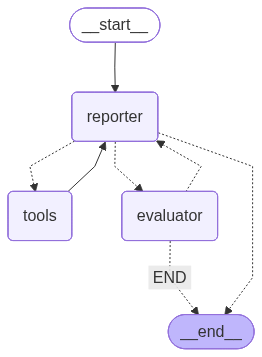

In [16]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
def make_thread_id() -> str:
    return str(uuid.uuid4())

async def process_message(message, topic, history, thread):

    config = {"configurable": {"thread_id": thread}}

    # Initial State
    state = {
        "messages": message,
        "topic": topic,
        "feedback_on_work": None,
        "success_criteria_met": False,
        "user_input_needed": False
    }
    result = await graph.ainvoke(state, config=config)
    user = {"role": "user", "content": message}
    reply = {"role": "assistant", "content": result["messages"][-2].content}
    feedback = {"role": "assistant", "content": result["messages"][-1].content}

    return history + [user, reply, feedback]

async def reset():
    return "", "", None, make_thread_id()

In [19]:
thread = make_thread_id()
config = {"configurable": {"thread_id": thread}}
message = "search the news"
topic = "otomotif listrik di indonesia"
# Initial State
state = {
    "messages": message,
    "topic": topic,
    "feedback_on_work": None,
    "success_criteria_met": False,
    "user_input_needed": False
}
result = await graph.ainvoke(state, config=config)

KeyError: 'reporter'

In [18]:

with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Report News")
    thread = gr.State(make_thread_id())
    
    with gr.Row():
        chatbot = gr.Chatbot(label="Report", height=300, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your request to your report")
        with gr.Row():
            topic = gr.Textbox(show_label=False, placeholder="What are your topic?")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    message.submit(process_message, [message, topic, chatbot, thread], [chatbot])
    topic.submit(process_message, [message, topic, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, topic, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, topic, chatbot, thread])

    
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/home/agrelvin8135@corp.ai.astra.co.id/Documents/Data/UdemyProject/Agentic-AI/.venv/lib/python3.12/site-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/agrelvin8135@corp.ai.astra.co.id/Documents/Data/UdemyProject/Agentic-AI/.venv/lib/python3.12/site-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/agrelvin8135@corp.ai.astra.co.id/Documents/Data/UdemyProject/Agentic-AI/.venv/lib/python3.12/site-packages/gradio/blocks.py", line 2220, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/agrelvin8135@corp.ai.astra.co.id/Documents/Data/UdemyProject/Agentic-AI/.venv/lib/python3.12/site-packages/gradio/blocks.py", line 1729, in call_function
    pred